In [1]:
import os
import json
import random
import torch
import numpy as np
import seaborn as sn
from tqdm import tqdm
from matplotlib import pyplot as plt
from opennre import encoder
from opennre.model import SoftmaxNN

from server.adversary_utils import *
from config import *
%matplotlib inline

In [2]:
def load_saliency(dataset_name, model_name, adversary_name):
    origin_list, adv_list = [], []
    for data_type in DATA_TYPES[dataset_name]:
        origin_file = os.path.join('dataset', dataset_name, model_name,
                                   '{}_ig.txt'.format(data_type))
        origin_saliency = [json.loads(line) for line in open(origin_file, 'r').readlines()]
        adv_file = os.path.join('dataset', dataset_name, model_name,
                                '{}_{}_ig.txt'.format(data_type, adversary_name))
        adv_saliency = [json.loads(line) for line in open(adv_file, 'r').readlines()]
        for adv in tqdm(adv_saliency, desc=adv_file):
            adv['data_type'] = data_type
            origin = origin_saliency[adv['index']]
            origin['data_type'] = data_type
            adv_list.append(adv)
            origin_list.append(origin)

    return origin_list, adv_list

修改后的token和实体，在训练时存在相关性，共现
没有出现oov，对目标关系是否有关系，模型随即预测，虚假显著关联

- Are permuted words saliency tokens?
- Why are adversarial samples misclassified? 1. correlation, 2. oov
sudo code
table

- adv->minimum adv (possible contribution)

- 3 pairs pic with ratio
    - change to all
    - change to saliency token
    - change to other token (why saliency doesn't change)

- ratio pic, same dataset but different adv

- different saliency top for origin & adv
    - [0, 1] -> [0, 0], [0, 1], [1, 0], [1, 1]
    - new tops, why? scatter plot: predict by trigger rules

- oov situation: possibly lower confidence

- colab

- appendix: samples for different adv; hyperparams (experimental setting)

- takeaways: generate adv quickly; oov / correlation, reduce it

In [3]:
all_samples = {d: 
               {m: 
                {a: load_saliency(d, m, a)
                 for a in ['hf', 'tf', 'pw']}
                for m in ['bert', 'bertentity']}
               for d in ['tacred', 'wiki80']}

dataset/wiki80/bertentity/val_pw_ig.txt: 100%|██████████| 1614/1614 [00:00<00:00, 369056.68it/s]


In [8]:
# 取一些样本放论文里
origin_samples, adv_samples = all_samples['tacred']['bertentity']['pw']
with open('tacred_bertentity_pw_sample_40.txt', 'w') as f:
    for _ in range(40):
        i = random.choice(range(len(origin_samples)))
        origin, adv = origin_samples[i], adv_samples[i]
        origin['tokens'] = [token for (token, score) in origin['supervised']]
        adv['tokens'] = [[token for (token, score) in adv['supervised']]]
        sample = {'origin': {'tokens': origin['tokens'], 'saliency': origin['unsupervised'],
                             'label': origin['label'], 'prediction': origin['prediction'], 'confidence': origin['confidence']},
                  'adversary': {'tokens': adv['tokens'], 'saliency': adv['unsupervised'],
                               'label': adv['label'], 'prediction': adv['prediction'], 'confidence': adv['confidence']}}
        f.write(json.dumps(sample) + '\n')

In [9]:
cnt = {'bert': {'tacred': 99008, 'wiki80': 55193},
      'bertentity': {'tacred': 98245, 'wiki80': 55225}}
for m in ['bert', 'bertentity']:
    for a in ['hf', 'pw', 'tf']:
        print("&{}/{:.2f}\% &{}/{:.2f}\% \\\\".format(len(all_samples['wiki80'][m][a][0]),
                                                      100 * len(all_samples['wiki80'][m][a][0]) / cnt[m]['wiki80'],
                                                      len(all_samples['tacred'][m][a][0]),
                                                      100 * len(all_samples['tacred'][m][a][0]) / cnt[m]['tacred']))
# BERT (HotFlip)&4,819 &4,953  \\
#  BERT (PWWS)&17,742 &27,476  \\
#  BERT (TextFooler)&26,774 &34,892  \\

#  MTB (HotFlip) &4,655 &3,868 \\
#  MTB (PWWS) &16,868 &21,692\\
#  MTB (TextFooler)&25,969 &25,751 \\

&4819/8.73\% &4953/5.00\% \\
&17742/32.15\% &27476/27.75\% \\
&26774/48.51\% &34892/35.24\% \\
&4655/8.43\% &3868/3.94\% \\
&16868/30.54\% &21692/22.08\% \\
&25969/47.02\% &25751/26.21\% \\


## Saliency scores of full sentence of adversary sample and original sample

In [54]:
all_change_src = {'top': [], 'other': [], 'both': []}
all_change_dst = {'top': [], 'other': [], 'both': []}
changes = []
unchanges = []
changes_sent = []
unchanges_sent = []
TOP_NUM = 3
count_dict = {}
origin_samples, adv_samples = all_samples['wiki80']['bert']['hf']
for idx, (origin, adv) in tqdm(enumerate(zip(origin_samples, adv_samples))):
    origin_tokens = [token for (token, score) in origin['supervised']]
    # Using unsupervised saliency
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)
    
    # Check deleted indices
    delete_indices = [idx for (idx, val) in enumerate(actions_origin) if val == -1]
    sorted_indices = np.argsort(origin_sal)[::-1].tolist()
    
    # Ignore fixed tokens, which shouldn't be changed during adversary
    fixed_indices = [origin_tokens.index('[CLS]')]
    if '[SEP]' in origin_tokens:
        fixed_indices.append(origin_tokens.index('[SEP]'))
    if '[unused0]' in origin_tokens and '[unused1]' in origin_tokens:
        h_pos = [origin_tokens.index('[unused0]'), origin_tokens.index('[unused1]')]
        fixed_indices += list(range(h_pos[0], h_pos[1] + 1))
    if '[unused2]' in origin_tokens and '[unused3]' in origin_tokens:
        t_pos = [origin_tokens.index('[unused2]'), origin_tokens.index('[unused3]')]
        fixed_indices += list(range(t_pos[0], t_pos[1] + 1))
    fixed_indices = set(fixed_indices)
    top_idx_set = set([idx for idx in sorted_indices if idx not in fixed_indices][:TOP_NUM])
    
    top_idx_num = len([idx for idx in delete_indices if idx in top_idx_set])
    other_idx_num = len(delete_indices) - top_idx_num
    pair = top_idx_num, other_idx_num
    if pair not in count_dict:
        count_dict[pair] = 0
    count_dict[pair] += 1
    
    if top_idx_num == 0:
        all_change_src['other'].append(idx)
    elif other_idx_num == 0:
        all_change_src['top'].append(idx)
    else:
        all_change_src['both'].append(idx)
    
    if actions_origin == actions_adv:
        tmp1 = [(origin_sal[idx], adv_sal[idx]) for idx in range(len(actions_origin)) if actions_origin[idx] == -1]
        tmp2 = [(origin_sal[idx], adv_sal[idx]) for idx in range(len(actions_origin)) if actions_origin[idx] != -1]
        changes.extend(tmp1)
        unchanges.extend(tmp2)
        changes_sent.append(tmp1)
        unchanges_sent.append(tmp2)
    
    # Check inserted indices
    insert_indices = [idx for (idx, val) in enumerate(actions_adv) if val == -1]
    top_idx_set = set(np.argsort(adv_sal)[::-1][:TOP_NUM].tolist())
    top_idx_num = len([idx for idx in delete_indices if idx in top_idx_set])
    other_idx_num = len(delete_indices) - top_idx_num
    if top_idx_num == 0:
        all_change_dst['other'].append(idx)
    elif other_idx_num == 0:
        all_change_dst['top'].append(idx)
    else:
        all_change_dst['both'].append(idx)

4819it [00:04, 1197.97it/s]


Density calculated.


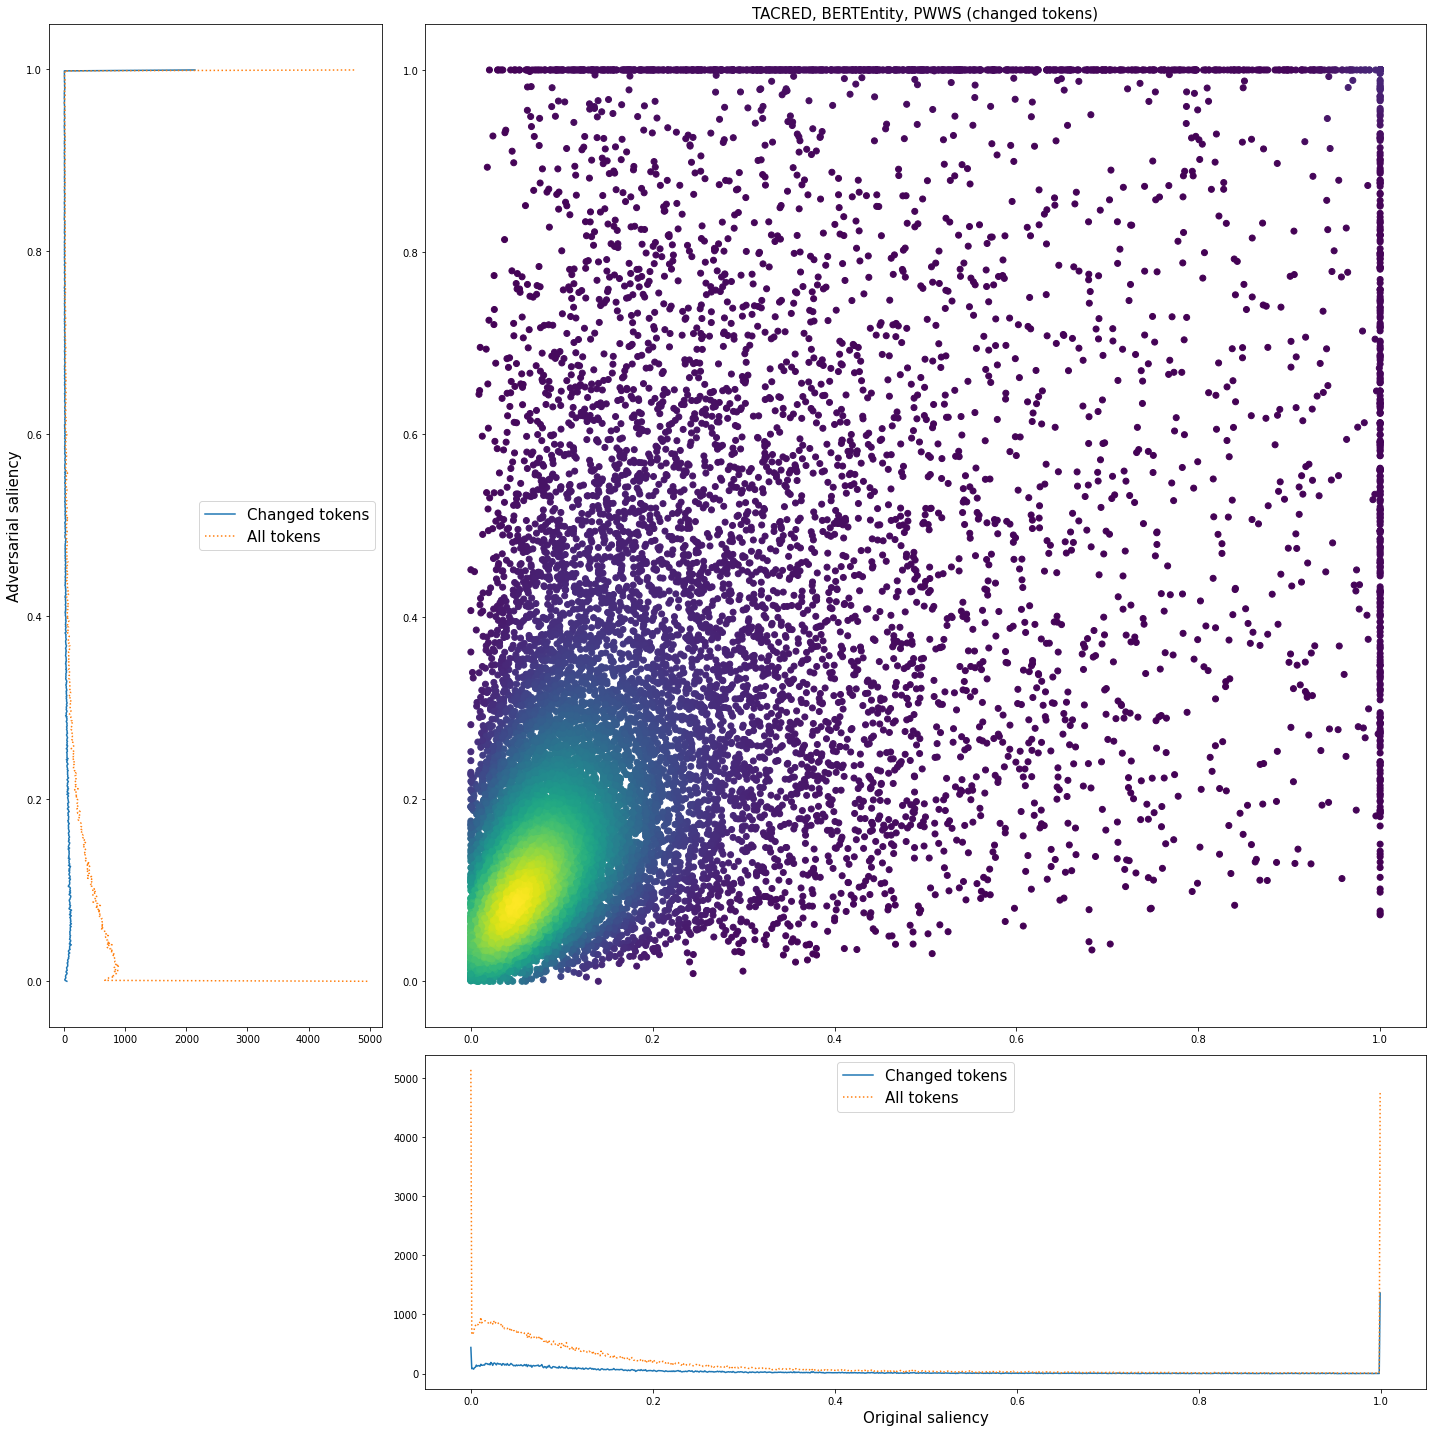

In [57]:
from scipy.stats import gaussian_kde
from matplotlib import gridspec

change_samples = random.sample(changes, len(changes) // 2)
xs_sample = [p[0] for p in change_samples]
ys_sample = [p[1] for p in change_samples]
xy = np.vstack([xs_sample,ys_sample])
z = gaussian_kde(xy)(xy)
print('Density calculated.')

fig = plt.figure(figsize=(20, 20))
widths = [5, 15]
heights = [15, 5]
specs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

# Draw 3 pics
ax = fig.add_subplot(specs[0, 1])
ax.scatter(x=xs_sample, y=ys_sample, c=z)
plt.title('TACRED, BERTEntity, PWWS (changed tokens)', fontsize=15)
plt.tight_layout()

xs = [p[0] for p in changes]
all_shift = changes + unchanges
xs_ = [p[0] for p in all_shift]
ys = [p[1] for p in changes]
ys_ = [p[1] for p in all_shift]

ax = fig.add_subplot(specs[1, 1])
a, b = np.histogram(xs, bins=1000)
a_, b_ = np.histogram(xs_, bins=1000)
ax.plot(b[:-1], a, label='Changed tokens', linestyle='-')
ax.plot(b_[:-1], a_, label='All tokens', linestyle='dotted')
plt.legend(fontsize=15)
plt.xlabel('Original saliency', fontsize=15)
plt.tight_layout()

ax = fig.add_subplot(specs[0, 0])
a, b = np.histogram(ys, bins=1000)
a_, b_ = np.histogram(ys_, bins=1000)
ax.plot(a, b[:-1], label='Changed tokens', linestyle='-')
ax.plot(a_, b_[:-1], label='All tokens', linestyle='dotted')
plt.legend(fontsize=15)
plt.ylabel('Adversarial saliency', fontsize=15)
plt.tight_layout()

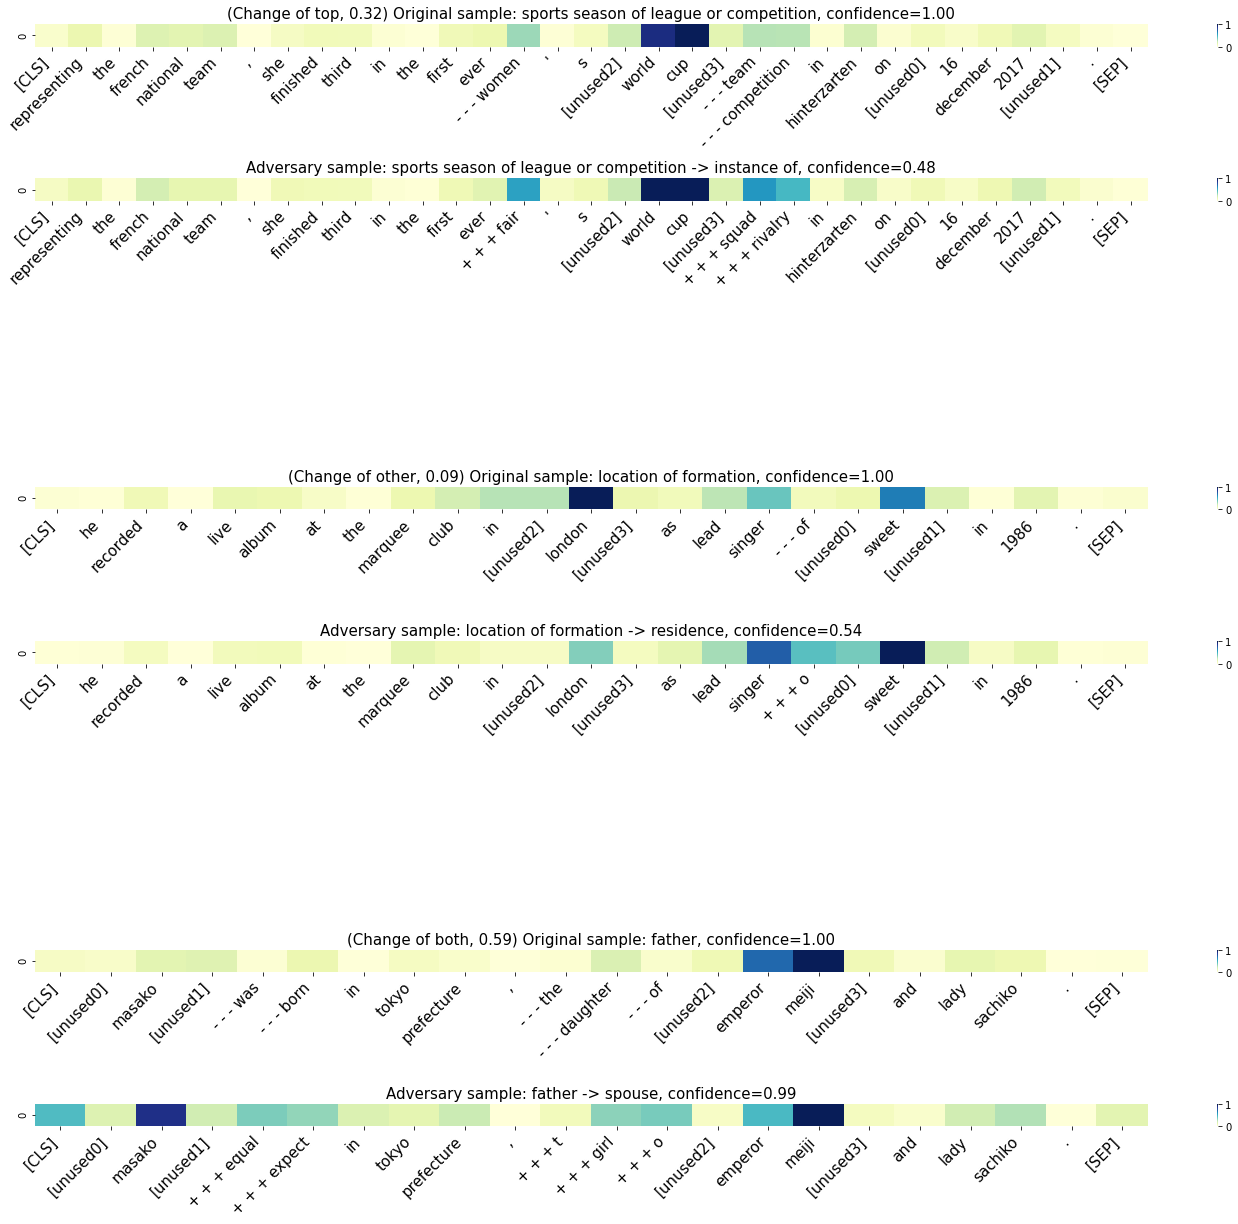

In [22]:
# Change of original tokens
plt.figure(figsize=(20, 18))
i = 0
for name, idx_list in all_change_src.items():
    idx = random.choice(idx_list)
    origin, adv = origin_samples[idx], adv_samples[idx]
    origin_tokens = [token for (token, score) in origin['supervised']]
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)
    # 3 parts: remain the same, inserted, deleted
    origin_tokens = [origin_tokens[idx] if val != -1 else '- - - {}'.format(origin_tokens[idx])
                    for (idx, val) in enumerate(actions_origin)]
    adv_tokens = [adv_tokens[idx] if val != -1 else '+ + + {}'.format(adv_tokens[idx])
                 for (idx, val) in enumerate(actions_adv)]

    plt.subplot(9, 1, 1 + i * 3)
    ax = sn.heatmap(data=np.array(origin_sal).reshape(1, -1),
                    xticklabels=origin_tokens,
                    cmap='YlGnBu')
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.title('(Change of {}, {:.2f}) Original sample: {}, confidence={:.2f}'.format(name,
                                                                                     len(idx_list) / len(adv_samples),
                                                                                     origin['label'],
                                                                                     origin['confidence']), fontsize=15)
    plt.tight_layout()

    plt.subplot(9, 1, 1 + i * 3 + 1)
    ax = sn.heatmap(data=np.array(adv_sal).reshape(1, -1),
                    xticklabels=adv_tokens,
                    cmap='YlGnBu')
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.title('Adversary sample: {} -> {}, confidence={:.2f}'.format(adv['label'],
                                                                     adv['prediction'],
                                                                     adv['confidence']), fontsize=15)
    plt.tight_layout()
    i += 1

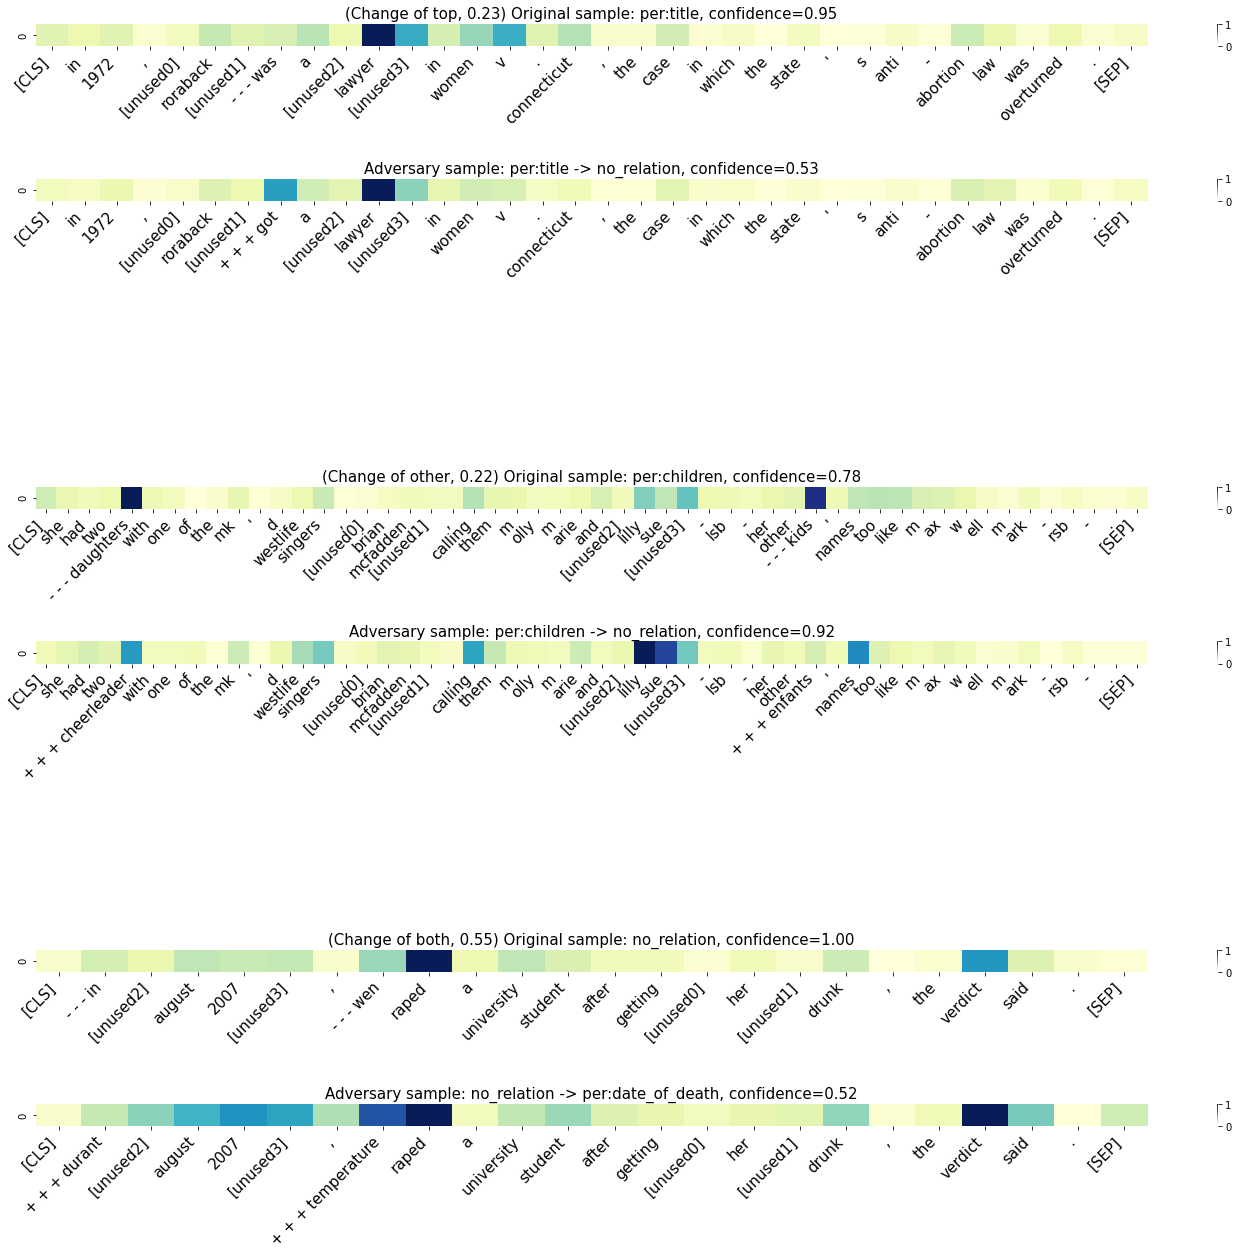

In [7]:
# Change of adversary tokens
plt.figure(figsize=(20, 18))
i = 0
for name, idx_list in all_change_dst.items():
    idx = random.choice(idx_list)
    origin, adv = origin_samples[idx], adv_samples[idx]
    origin_tokens = [token for (token, score) in origin['supervised']]
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)
    # 3 parts: remain the same, inserted, deleted
    origin_tokens = [origin_tokens[idx] if val != -1 else '- - - {}'.format(origin_tokens[idx])
                    for (idx, val) in enumerate(actions_origin)]
    adv_tokens = [adv_tokens[idx] if val != -1 else '+ + + {}'.format(adv_tokens[idx])
                 for (idx, val) in enumerate(actions_adv)]

    plt.subplot(9, 1, 1 + i * 3)
    ax = sn.heatmap(data=np.array(origin_sal).reshape(1, -1),
                    xticklabels=origin_tokens,
                    cmap='YlGnBu')
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.title('(Change of {}, {:.2f}) Original sample: {}, confidence={:.2f}'.format(name,
                                                                                     len(idx_list) / len(adv_samples),
                                                                                     origin['label'],
                                                                                     origin['confidence']), fontsize=15)
    plt.tight_layout()

    plt.subplot(9, 1, 1 + i * 3 + 1)
    ax = sn.heatmap(data=np.array(adv_sal).reshape(1, -1),
                    xticklabels=adv_tokens,
                    cmap='YlGnBu')
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.title('Adversary sample: {} -> {}, confidence={:.2f}'.format(adv['label'],
                                                                     adv['prediction'],
                                                                     adv['confidence']), fontsize=15)
    plt.tight_layout()
    i += 1

In [55]:
# Check how many sentences have great saliency changes?
big_change_cnt = []
BIG = 0.3
for a, b in tqdm(zip(changes_sent, unchanges_sent)):
    big = len([p for p in a + b if np.abs(p[0] - p[1]) >= BIG])
    big_change_cnt.append(big)

4771it [00:00, 19080.54it/s]


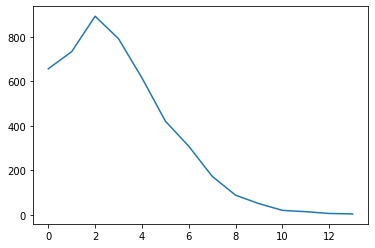

In [56]:
y, x = np.histogram(big_change_cnt, bins=np.unique(big_change_cnt))
plt.plot(x[:-1], y)

## Entropy

34892it [00:14, 2386.98it/s]


Density calculated.


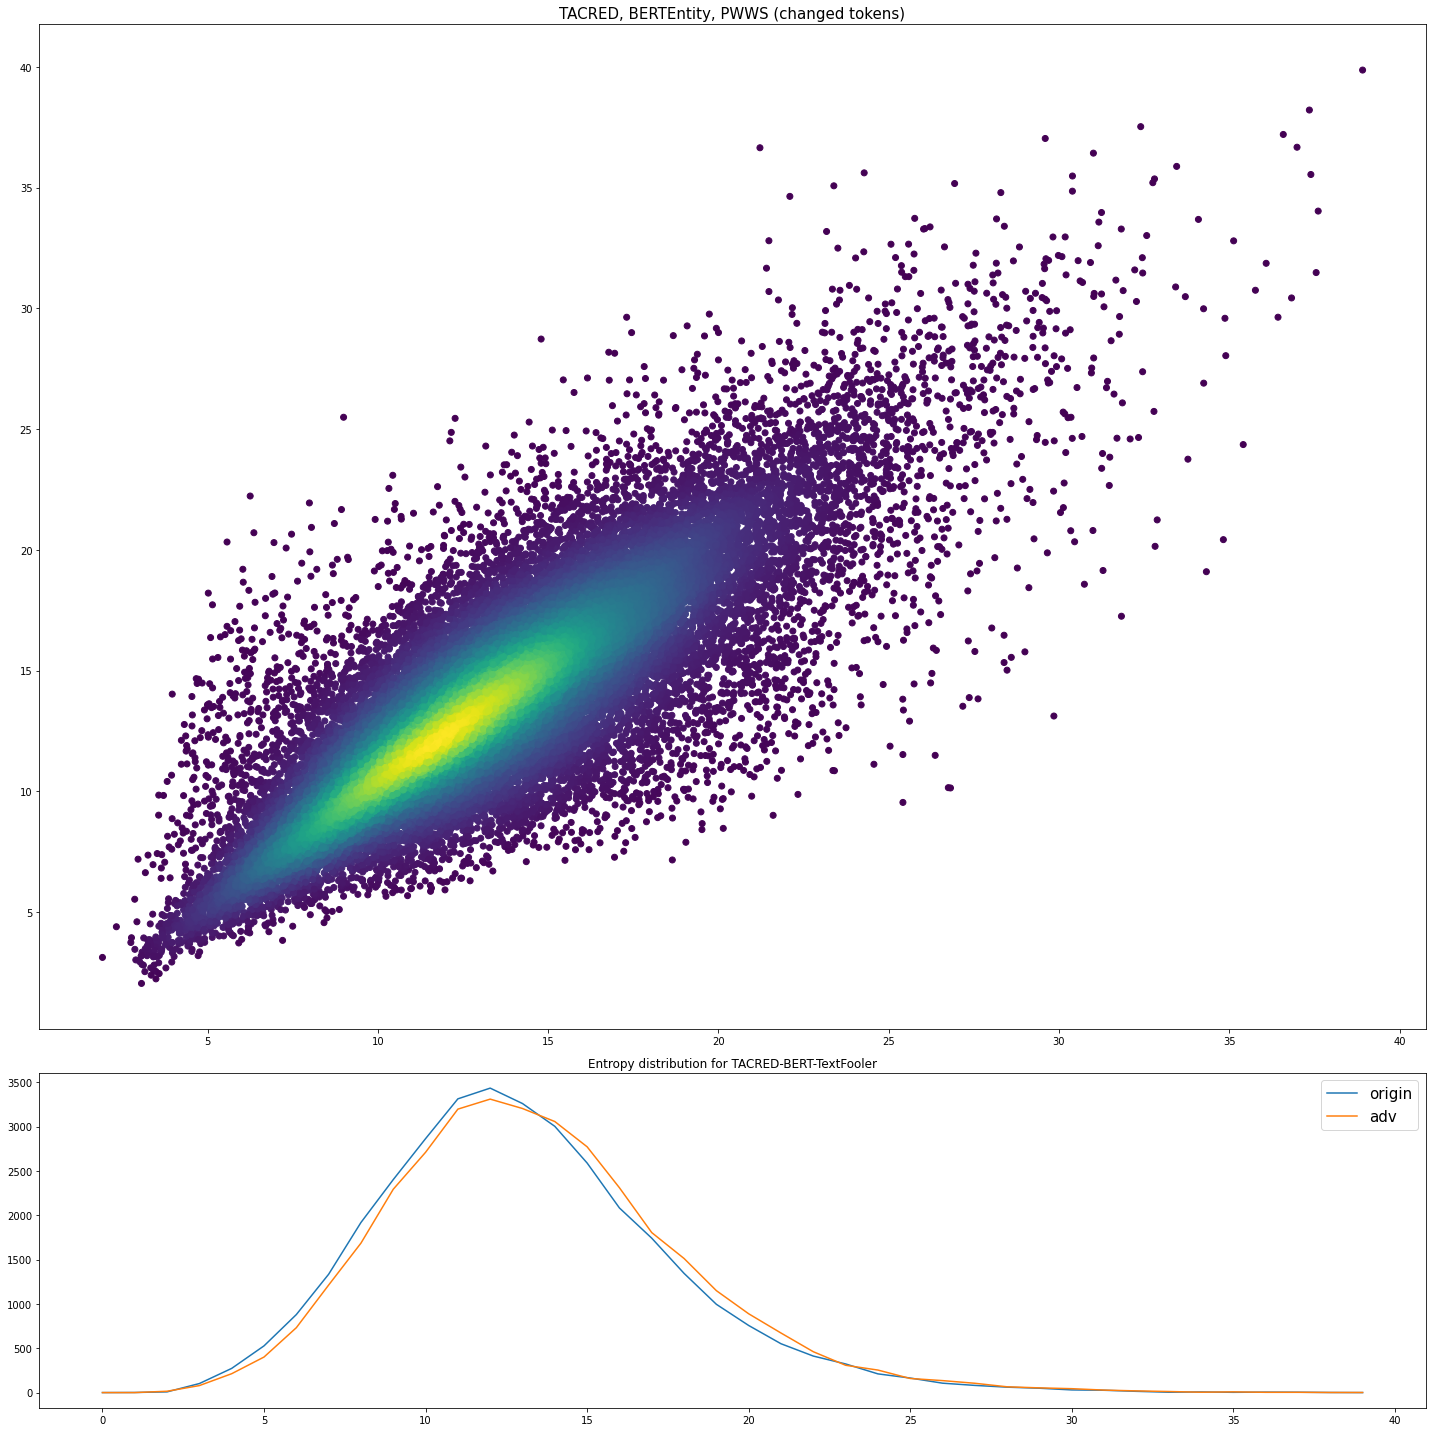

In [34]:
from scipy.stats import entropy
from scipy.stats import gaussian_kde
from matplotlib import gridspec

origin_samples, adv_samples = all_samples['tacred']['bert']['tf']
e1, e2 = [], []
for origin, adv in tqdm(zip(origin_samples, adv_samples)):
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    e1.append(sum([-p*np.log2(p + 1e-6) for p in origin_sal]))
    e2.append(sum([-p*np.log2(p + 1e-6) for p in adv_sal]))


fig = plt.figure(figsize=(20, 20))
heights = [15, 5]
specs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

# Draw 2 pics
xy = np.vstack([e1, e2])
z = gaussian_kde(xy)(xy)
print('Density calculated.')
ax = fig.add_subplot(specs[0, 0])
ax.scatter(x=e1, y=e2, c=z)
plt.title('TACRED, BERTEntity, PWWS (changed tokens)', fontsize=15)
plt.tight_layout()

ax = fig.add_subplot(specs[1, 0])
max_e, min_e = int(np.max(e1 + e2)) + 1, int(np.min(e1 + e2)) - 1
y1, x1 = np.histogram(e1, bins=range(min_e, max_e + 1))
y2, x2 = np.histogram(e2, bins=range(min_e, max_e + 1))
plt.plot(x1[:-1], y1, label='origin')
plt.plot(x2[:-1], y2, label='adv')
plt.title('Entropy distribution for TACRED-BERT-TextFooler')
plt.legend(fontsize=15)
plt.tight_layout()

## Look into samples!!!

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
        55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
        66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
        77.5, 78.5, 79.5]),
 <a list of 80 Text major ticklabel objects>)

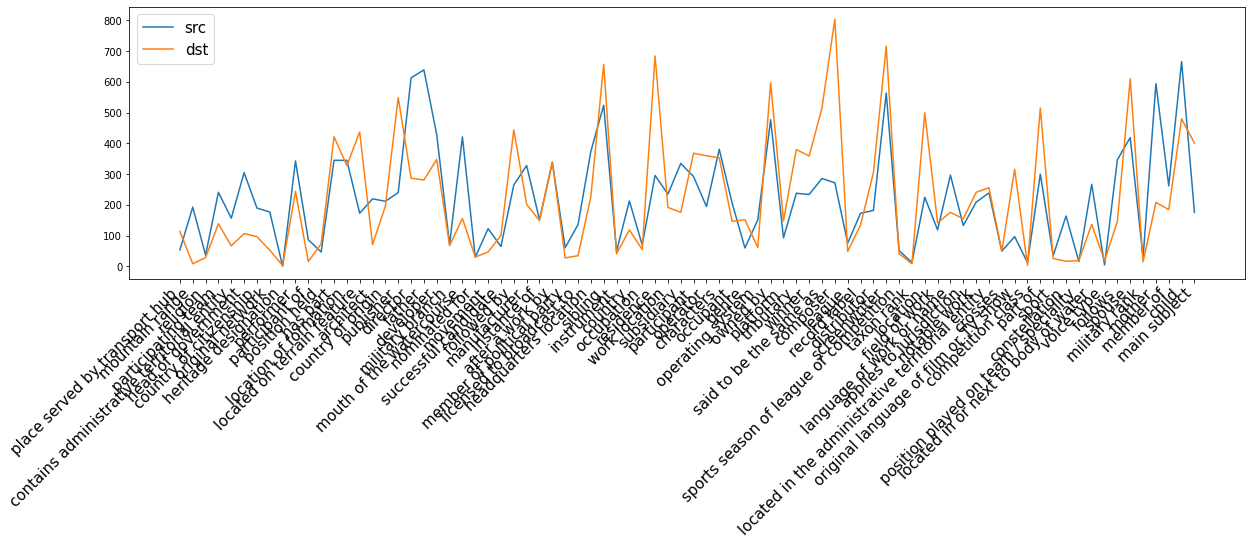

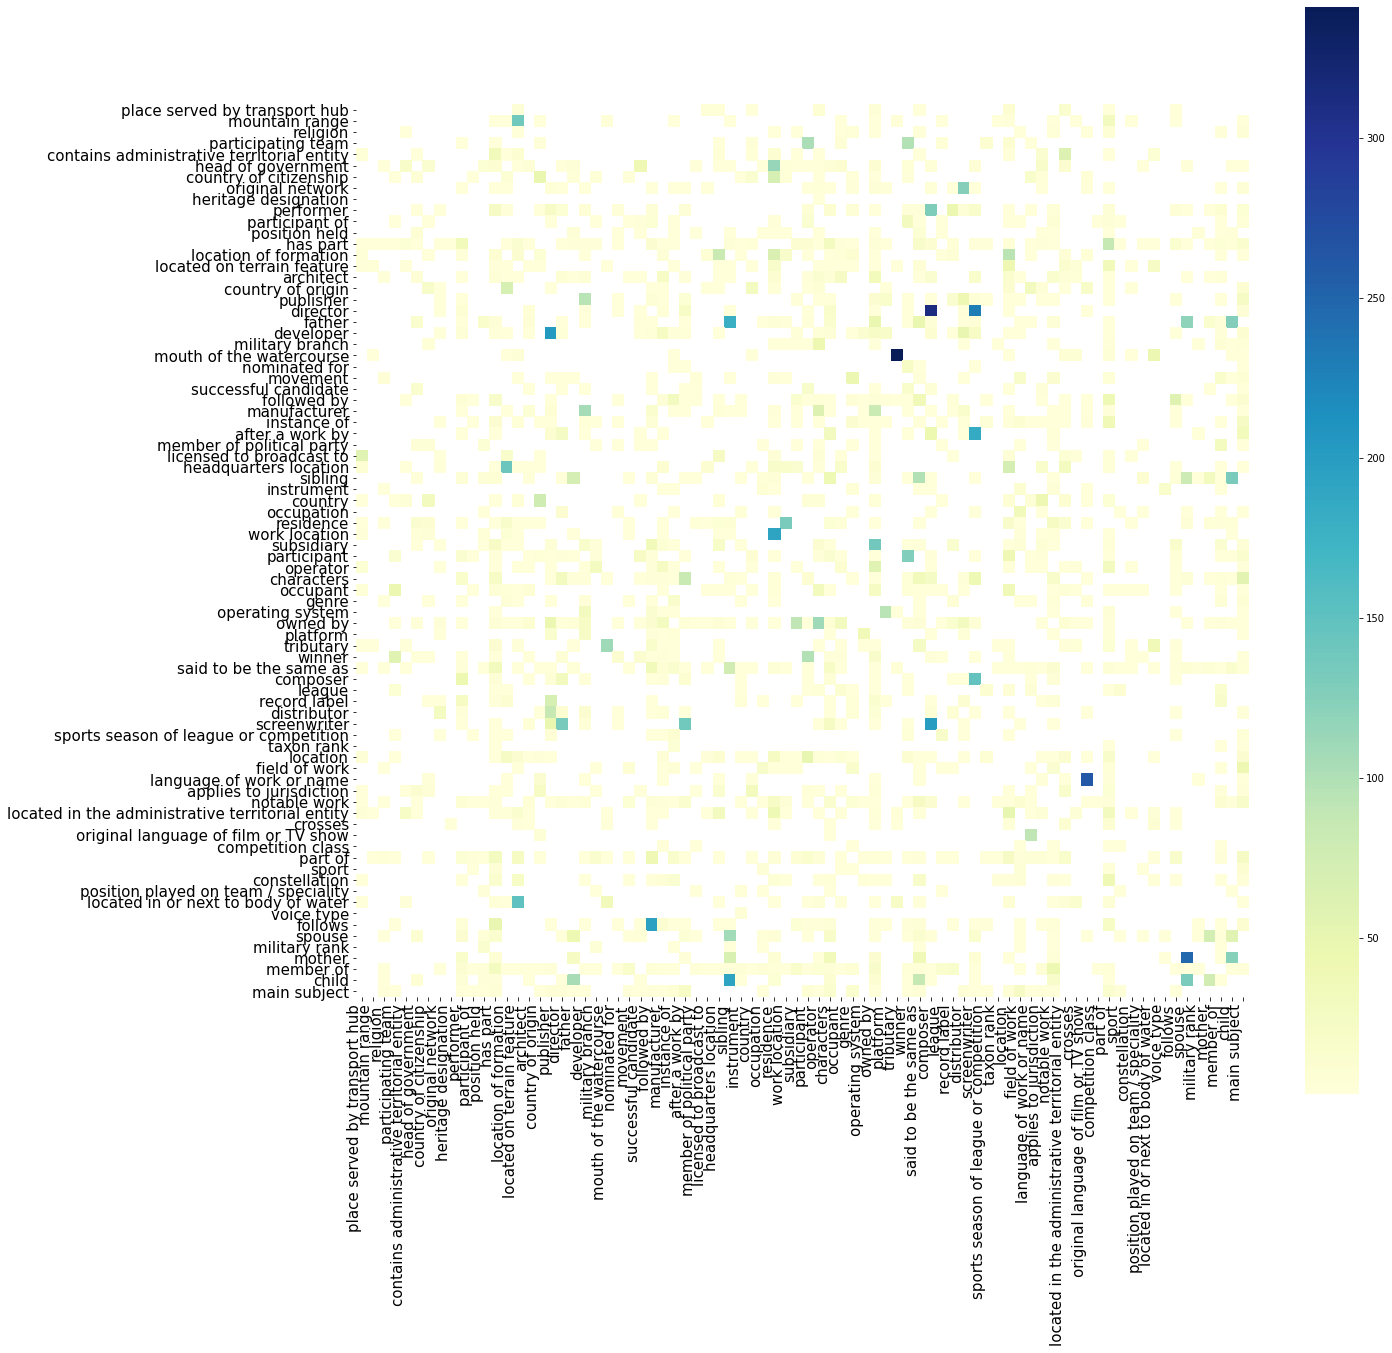

In [70]:
origin_samples, adv_samples = all_samples['wiki80']['bert']['pw']
src, dst = {}, {}
rel2id = json.load(open('dataset/wiki80/rel2id.json', 'r'))
x = list(rel2id.keys())
shift = np.zeros((len(x), len(x)))
for adv in adv_samples:
    label, pred = adv['label'], adv['prediction']
    src[label] = src.get(label, 0) + 1
    dst[pred] = dst.get(pred, 0) + 1
    if label != 'no_relation' and pred != 'no_relation':
        shift[rel2id[label]][rel2id[pred]] += 1

src_y = [src.get(k, 0) for k in x]
dst_y = [dst.get(k, 0) for k in x]

plt.figure(figsize=(20, 5))
plt.plot(x, src_y, label='src')
plt.plot(x, dst_y, label='dst')
plt.legend(fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=15)

plt.figure(figsize=(20, 20))
sn.heatmap(data=shift, xticklabels=x, yticklabels=x,
           cmap='YlGnBu', square=True, mask=shift==0)
plt.xticks(rotation=90, ha='right', fontsize=15)
plt.yticks(ha='right', fontsize=15)

## OOV & Misleading

In [4]:
# Build up word frequency dict for training samples
train_samples = [json.loads(line) for line in open('dataset/tacred/train.txt', 'r').readlines()]
word_count = {}
for sample in tqdm(train_samples):
    tokens = sample['token']
    label = sample['relation']
    for tok in tokens:
        if tok not in word_count:
            word_count[tok] = []
        word_count[tok].append(label)

100%|██████████| 68124/68124 [00:01<00:00, 36723.22it/s]


In [37]:
oov_count, confidence_diff = 0, []
word_rel_dict = {}
origin_samples, adv_samples = all_samples['tacred']['bert']['tf']
for idx, (origin, adv) in tqdm(enumerate(zip(origin_samples, adv_samples))):
    if adv['prediction'] == 'no_relation':  # Remove no_relation predictions
        continue
    
    origin_tokens = [token for (token, score) in origin['supervised']]
    # Using unsupervised saliency
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)
    
    inserted_tokens = [adv_tokens[idx] for idx in range(len(actions_adv)) if actions_adv[idx] == -1]
    if len(inserted_tokens) > 1:  # Remove multiple chanegs
        continue

    pred_label = adv['prediction']
    
    mislead = False
    for tok in inserted_tokens:
        if tok not in word_count:
            oov_count += 1
        else:
            word_rel_dict[(tok, pred_label)] = word_rel_dict.get((tok, pred_label), 0) + 1
    confidence_diff.append(adv['confidence'] - origin['confidence'])

34892it [00:38, 903.52it/s] 


In [40]:
stopwords = {line.strip() for line in open('stopwords.txt', 'r')}
filt_pairs = [p for p in word_rel_dict.items() if p[0][0] not in stopwords]
filt_pairs = sorted(filt_pairs, key=lambda p: -p[1])
# Merge them to see specific tokens
merge_keys = {}
for ((word, rel), cnt) in filt_pairs:
    if word not in merge_keys:
        merge_keys[word] = {'total': 0}
    merge_keys[word][rel] = cnt
    merge_keys[word]['total'] += cnt
sort_merge_keys = sorted(merge_keys.items(), key=lambda p: -p[1]['total'])
len(sort_merge_keys)

766

In [41]:
sort_merge_keys[:100]

[('avec',
  {'total': 75,
   'org:alternate_names': 13,
   'org:country_of_headquarters': 12,
   'org:top_members/employees': 10,
   'per:title': 6,
   'org:parents': 6,
   'per:employee_of': 5,
   'org:subsidiaries': 5,
   'per:cities_of_residence': 4,
   'per:countries_of_residence': 4,
   'per:charges': 2,
   'per:origin': 2,
   'per:date_of_death': 2,
   'per:age': 1,
   'per:spouse': 1,
   'org:stateorprovince_of_headquarters': 1,
   'org:city_of_headquarters': 1}),
 ('de',
  {'total': 54,
   'per:title': 11,
   'org:alternate_names': 9,
   'per:employee_of': 6,
   'org:country_of_headquarters': 6,
   'org:top_members/employees': 3,
   'org:subsidiaries': 3,
   'per:charges': 3,
   'org:founded': 2,
   'per:children': 2,
   'per:origin': 1,
   'per:cities_of_residence': 1,
   'org:members': 1,
   'org:parents': 1,
   'per:countries_of_residence': 1,
   'org:political/religious_affiliation': 1,
   'org:founded_by': 1,
   'per:date_of_birth': 1,
   'per:date_of_death': 1}),
 ('en',


In [111]:
# What's the relationship between saliency change and confidence change?
changes_sent[0], origin_samples[0]['prediction'],
origin_samples[0]['confidence'], adv_samples[0]['prediction'], adv_samples[0]['confidence']

([(0.4060375690460205, 0.3764522969722748),
  (0.5013283491134644, 0.28622692823410034),
  (0.31756001710891724, 0.3389766812324524),
  (0.22704097628593445, 0.23839130997657776),
  (0.26627323031425476, 0.20429736375808716),
  (0.9472125172615051, 1.0)],
 'per:children',
 0.8310924768447876,
 'per:siblings',
 0.40472573041915894)

2021-01-27 04:54:53,912 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


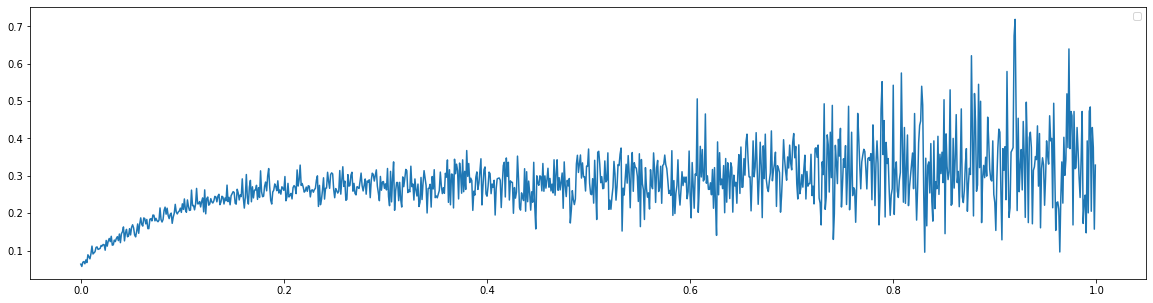

In [138]:
a, b = np.histogram([p[0] for p in changes + unchanges], bins=1000)
a = a / len(tmp)
a_, b_ = np.histogram([p[0] for p in changes], bins=1000)
a_ = a_ / len(changes)
plt.figure(figsize=(20, 5))
plt.plot(b[:-1], a_ / a)
# plt.plot(b[:-1], a, label='all tokens', linestyle='-')
# plt.plot(b_[:-1], a_, label='changed tokens', linestyle='dotted', color='red')
plt.legend()

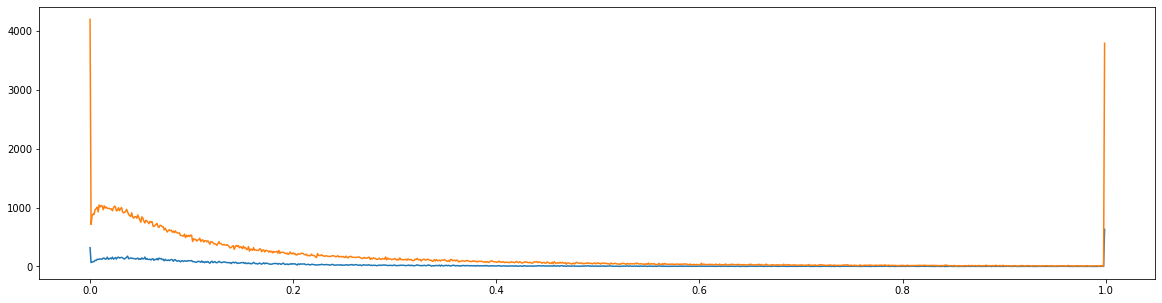

In [103]:
plt.figure(figsize=(20, 5))
a, b = np.histogram([p[0] for p in tmp], bins=1000)
a_, b_ = np.histogram([p[0] for p in changes], bins=1000)
plt.plot(b[:-1], a_)
plt.plot(b[:-1], a)

In [17]:
[(k, count_dict[k]) for k in sorted(count_dict)]

[((0, 1), 4465),
 ((0, 2), 3575),
 ((0, 3), 2544),
 ((0, 4), 2090),
 ((0, 5), 1699),
 ((0, 6), 1519),
 ((0, 7), 1315),
 ((0, 8), 1086),
 ((0, 9), 959),
 ((0, 10), 780),
 ((0, 11), 630),
 ((0, 12), 501),
 ((0, 13), 380),
 ((0, 14), 271),
 ((0, 15), 169),
 ((0, 16), 94),
 ((0, 17), 63),
 ((0, 18), 29),
 ((0, 19), 15),
 ((0, 20), 8),
 ((0, 21), 7),
 ((0, 22), 1),
 ((0, 23), 2),
 ((0, 24), 2),
 ((0, 25), 1),
 ((0, 29), 1),
 ((0, 30), 1),
 ((1, 0), 4269),
 ((1, 1), 1736),
 ((1, 2), 962),
 ((1, 3), 772),
 ((1, 4), 665),
 ((1, 5), 558),
 ((1, 6), 525),
 ((1, 7), 474),
 ((1, 8), 390),
 ((1, 9), 381),
 ((1, 10), 340),
 ((1, 11), 245),
 ((1, 12), 224),
 ((1, 13), 148),
 ((1, 14), 99),
 ((1, 15), 67),
 ((1, 16), 41),
 ((1, 17), 17),
 ((1, 18), 10),
 ((1, 19), 5),
 ((1, 22), 1),
 ((1, 32), 1),
 ((2, 0), 111),
 ((2, 1), 83),
 ((2, 2), 67),
 ((2, 3), 59),
 ((2, 4), 45),
 ((2, 5), 55),
 ((2, 6), 51),
 ((2, 7), 54),
 ((2, 8), 45),
 ((2, 9), 47),
 ((2, 10), 33),
 ((2, 11), 24),
 ((2, 12), 23),
 ((2, 13

## Reveal process of model prediction

In [71]:
def token2sample(tokens, rel):
    if tokens[0] == '[CLS]':
        tokens = tokens[1:]
    if tokens[-1] == '[SEP]':
        tokens = tokens[:-1]
    sent = ' '.join(tokens)
    # Convert into a legal sample
    pos0, pos1, pos2, pos3 = [sent.find(w) for w in
                              ['[unused0]', '[unused1]', '[unused2]', '[unused3]']]
    rev = pos0 > pos2
    h, t = sent[pos0 + len('[unused0]'):pos1], sent[pos2 + len('[unused2]'):pos3]
    if rev:
        s1, s2 = sent[:pos2], sent[pos3 + len('[unused3]'):pos0]
        s3 = sent[pos1 + len('[unused1]'):]
    else:
        s1, s2 = sent[:pos0], sent[pos1 + len('[unused1]'):pos2]
        s3 = sent[pos3 + len('[unused3]'):]
    # Convert string to token ids
    h, t, s1, s2, s3 = [part.strip().split()
                        for part in [h, t, s1, s2, s3]]
    if rev:
        words = s1 + t + s2 + h + s3
        h_pos = [len(s1) + len(t) + len(s2)]
        h_pos.append(h_pos[0] + len(h))
        t_pos = [len(s1)]
        t_pos.append(t_pos[0] + len(t))
    else:
        words = s1 + h + s2 + t + s3
        h_pos = [len(s1)]
        h_pos.append(h_pos[0] + len(h))
        t_pos = [len(s1) + len(h) + len(s2)]
        t_pos.append(t_pos[0] + len(t))
    return {'token': words, 'h': {'pos': h_pos}, 't': {'pos': t_pos}, 'relation': rel}


def load_model(_dataset_name, _model_name, _rel2id):
    # Silent unimportant log messages
    for logger_name in ['transformers.configuration_utils',
                        'transformers.modeling_utils',
                        'transformers.tokenization_utils_base', 'absl']:
        logging.getLogger(logger_name).setLevel(logging.WARNING)
    # Load model by path
    _encoders = {'bert': encoder.BERTEncoder,
                 'bertentity': encoder.BERTEntityEncoder}
    if _model_name in _encoders:
        _sentence_encoder = _encoders[_model_name](
            max_length=MAX_SEQ_LEN,
            pretrain_path=PRETRAIN_PATH,
            mask_entity=False
        )
        _model = SoftmaxNN(_sentence_encoder, len(_rel2id), _rel2id)
        _model.load_state_dict(torch.load(MODEL_PATH_DICT[_dataset_name][_model_name],
                                          map_location=device)['state_dict'])
        _model.to(device)
        _model.eval()

        return _model
    else:
        raise NotImplementedError

In [75]:
rel2id = json.load(open(RELATION_PATH_DICT['wiki80'], 'r'))
id2rel = {v: k for (k, v) in rel2id.items()}
device = torch.device('cuda:1')
model = load_model('wiki80', 'bert', rel2id)

2021-01-30 03:21:38,819 - root - INFO - Loading BERT pre-trained checkpoint.


### Single sample changes

In [164]:
# from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets, decomposition


origin_samples, adv_samples = all_samples['tacred']['bert']['tf']

while True:
    index = random.choice(range(len(origin_samples)))
    origin, adv = origin_samples[index], adv_samples[index]
    origin_tokens = [token for (token, score) in origin['supervised']]
    # Using unsupervised saliency
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)

    if actions_origin == actions_adv:
        break

# See the visualization of embedding vector
modify_indices = [idx for (idx, val) in enumerate(actions_origin) if val == -1]

input_storage = []
gradient_storage = []
input_hook = model.sentence_encoder.bert.embeddings.register_forward_hook(
        lambda module, input_data, output_data:
        input_storage.append(
            output_data.detach().squeeze(0).cpu().numpy()))  # (128, 768)
#     gradient_hook = model.sentence_encoder.bert.embeddings.register_backward_hook(
#             lambda module, grad_input, grad_output:
#             gradient_storage.append(
#                 grad_input[0].detach().squeeze(0).cpu().numpy()))  # (128, 768)

# Get input vector of original vectors
sample = token2sample(origin_tokens, adv['label'])
it, am = model.sentence_encoder.tokenize(sample)
logits = model.softmax(model.forward(it.to(device), am.to(device)))

# Get input vector of adversary vectors
sample = token2sample(adv_tokens, adv['label'])
it, am = model.sentence_encoder.tokenize(sample)
logits = model.softmax(model.forward(it.to(device), am.to(device)))

input_hook.remove()
#     gradient_hook.remove()

indices1 = list(range(len(origin_tokens)))
embed_origin = [input_storage[0][idx] for idx in indices1]
embed_adv = [input_storage[1][idx] for idx in indices1]
#     grad = np.concatenate(gradient_storage, axis=0)

print('\t'.join([tok if idx not in modify_indices else '- - - ' + tok for (idx, tok) in enumerate(origin_tokens)]))
print('\t'.join([tok if idx not in modify_indices else '+ + + ' + tok for (idx, tok) in enumerate(adv_tokens)]))

[CLS]	[unused0]	maria	kaczynska	[unused1]	'	s	body	,	in	a	wooden	casket	- - - draped	- - - with	[unused2]	poland	[unused3]	'	s	white	-	and	-	red	flag	,	arrived	in	a	military	- - - casa	plane	shortly	after	10	:	30	- - - a	.	m	.	at	warsaw	'	s	okecie	- - - airport	.	[SEP]
[CLS]	[unused0]	maria	kaczynska	[unused1]	'	s	body	,	in	a	wooden	casket	+ + + ruffled	+ + + utilize	[unused2]	poland	[unused3]	'	s	white	-	and	-	red	flag	,	arrived	in	a	military	+ + + home	plane	shortly	after	10	:	30	+ + + another	.	m	.	at	warsaw	'	s	okecie	+ + + heathrow	.	[SEP]


In [165]:
# Modified t-SNE
insert_embed = [embed_adv[idx] for idx in modify_indices]
embed = np.array(embed_origin + insert_embed)

reduce_dim = min(len(embed), 200)
pca = decomposition.PCA(n_components=reduce_dim, random_state=1)
embed_pca = pca.fit_transform(embed)

tsne = manifold.TSNE(n_components=2, n_iter=500,
                     random_state=1, verbose=True)
embed_tsne = tsne.fit_transform(embed_pca)

[t-SNE] Computing 54 nearest neighbors...
[t-SNE] Indexed 55 samples in 0.000s...
[t-SNE] Computed neighbors for 55 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 55 / 55
[t-SNE] Mean sigma: 5.354525
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.507107
[t-SNE] KL divergence after 500 iterations: 0.579151


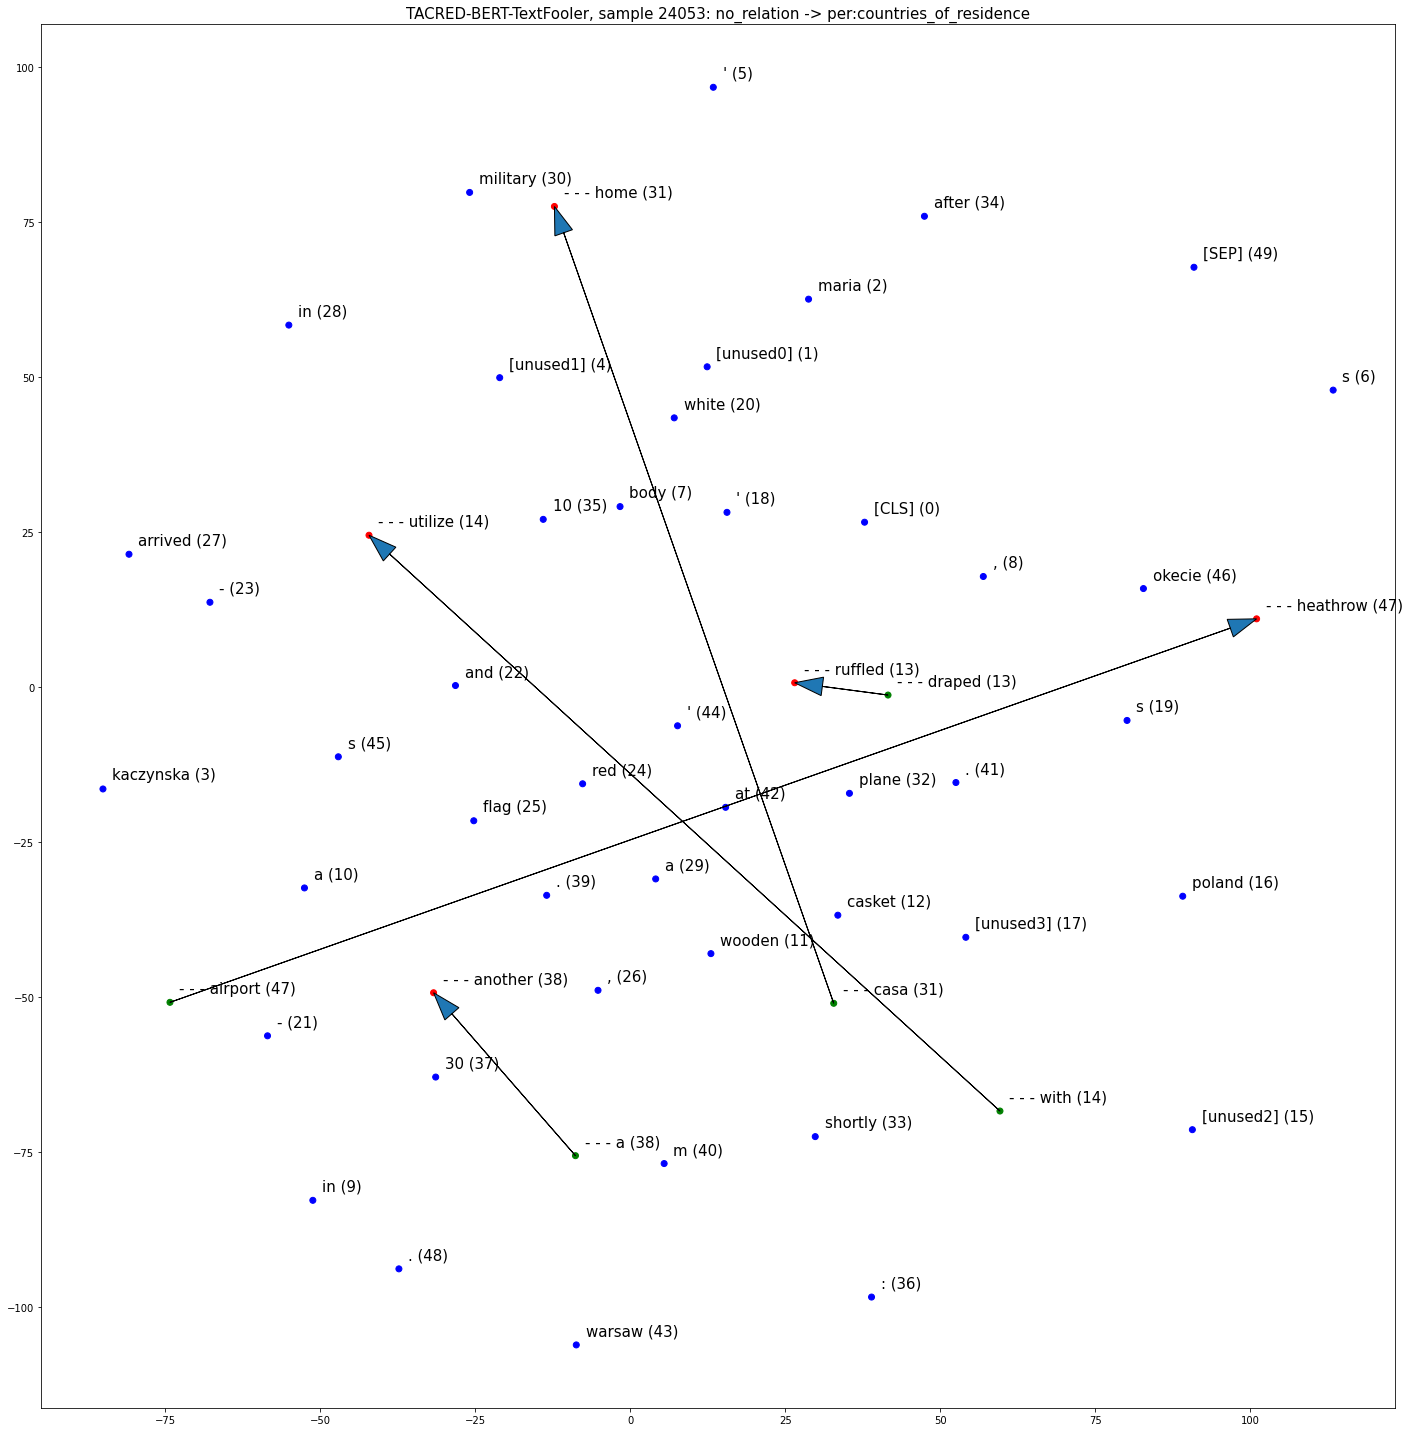

In [169]:
# Make color groups
colors = ['b' if idx not in modify_indices else 'g'
          for idx in range(len(origin_tokens))]  # Colors for original tokens
colors += ['r'] * len(modify_indices)
labels = ['{} ({})'.format(tok, idx) if idx not in modify_indices else '- - - {} ({})'.format(tok, idx)
          for (idx, tok) in enumerate(origin_tokens)]
labels += ['- - - {} ({})'.format(adv_tokens[idx], idx) for idx in modify_indices]

plt.figure(figsize=(20, 20))
plt.scatter(x=embed_tsne[:, 0], y=embed_tsne[:, 1], c=colors, marker='o')

arrow_width = max(embed_tsne[:, 0]) // 50 + 1
for i, j in enumerate(modify_indices):
    idx_from, idx_to = j, len(origin_tokens) + i
    x1, y1 = embed_tsne[idx_from]
    x2, y2 = embed_tsne[idx_to]
    plt.arrow(x1, y1, x2 - x1, y2 - y1, shape='full', head_width=arrow_width, lw=1, length_includes_head=True)
for idx, txt in enumerate(labels):
    plt.annotate(txt, (embed_tsne[idx][0] + arrow_width / 2, embed_tsne[idx][1] + arrow_width / 2), fontsize=15)
plt.title('TACRED-BERT-TextFooler, sample {}: {} -> {}'.format(index, adv['label'], adv['prediction']),
          fontsize=15)
plt.tight_layout()
plt.show()

### Many samples; different tokens

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets, decomposition


origin_samples, adv_samples = all_samples['tacred']['bert']['tf']

while True:
    index = random.choice(range(len(origin_samples)))
    origin, adv = origin_samples[index], adv_samples[index]
    origin_tokens = [token for (token, score) in origin['supervised']]
    # Using unsupervised saliency
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)

    if actions_origin == actions_adv:
        break

# See the visualization of embedding vector
modify_indices = [idx for (idx, val) in enumerate(actions_origin) if val == -1]

input_storage = []
gradient_storage = []
input_hook = model.sentence_encoder.bert.embeddings.register_forward_hook(
        lambda module, input_data, output_data:
        input_storage.append(
            output_data.detach().squeeze(0).cpu().numpy()))  # (128, 768)
#     gradient_hook = model.sentence_encoder.bert.embeddings.register_backward_hook(
#             lambda module, grad_input, grad_output:
#             gradient_storage.append(
#                 grad_input[0].detach().squeeze(0).cpu().numpy()))  # (128, 768)

# Get input vector of original vectors
sample = token2sample(origin_tokens, adv['label'])
it, am = model.sentence_encoder.tokenize(sample)
logits = model.softmax(model.forward(it.to(device), am.to(device)))

# Get input vector of adversary vectors
sample = token2sample(adv_tokens, adv['label'])
it, am = model.sentence_encoder.tokenize(sample)
logits = model.softmax(model.forward(it.to(device), am.to(device)))

input_hook.remove()
#     gradient_hook.remove()

indices1 = list(range(len(origin_tokens)))
embed_origin = [input_storage[0][idx] for idx in indices1]
embed_adv = [input_storage[1][idx] for idx in indices1]
#     grad = np.concatenate(gradient_storage, axis=0)

print('\t'.join([tok if idx not in modify_indices else '- - - ' + tok for (idx, tok) in enumerate(origin_tokens)]))
print('\t'.join([tok if idx not in modify_indices else '+ + + ' + tok for (idx, tok) in enumerate(adv_tokens)]))

## Look into token changes

In [53]:
min_samples_desc = []
min_changes_desc = []
min_samples_asc = []
min_changes_asc = []

max_len = 128
tk = model.sentence_47990/47990encoder.tokenizer

for origin, adv in tqdm(zip(origin_samples, adv_samples)):
    origin_tokens = [token for (token, score) in origin['supervised']]
    # Using unsupervised saliency
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)
    
    if actions_origin != actions_adv:
        continue
    
    delete_indices = [idx for (idx, val) in enumerate(actions_origin) if val == -1]
    # Sort the deleted indices by saliency of their token
    desc_indices = sorted(delete_indices, key=lambda idx: -origin_sal[idx])
    asc_indices = sorted(delete_indices, key=lambda idx: origin_sal[idx])
    
    # Descending saliency
    change = 0
    tmp = adv_tokens.copy()

    for idx in desc_indices:
        # Change the token
        tmp[idx] = origin_tokens[idx]
        change += 1
        
        # Predict label
        sample = token2sample(tmp, adv['label'])
        it, am = model.sentence_encoder.tokenize(sample)
        logits = model.softmax(model.forward(it.to(device), am.to(device)))
        score, pred = logits.max(-1)
        score = score.item()
        pred = pred.item()
        pred_label = id2rel[pred]

        # Check the result
        if pred_label == adv['label']:
            min_samples_desc.append(sample)
            min_changes_desc.append(change)
            break
    
    # Ascending saliency
    change = 0
    tmp = adv_tokens.copy()

    for idx in asc_indices:
        # Change the token
        tmp[idx] = origin_tokens[idx]
        change += 1
        
        # Predict label
        sample = token2sample(tmp, adv['label'])
        it, am = model.sentence_encoder.tokenize(sample)
        logits = model.softmax(model.forward(it.to(device), am.to(device)))
        score, pred = logits.max(-1)
        score = score.item()
        pred = pred.item()
        pred_label = id2rel[pred]

        # Check the result
        if pred_label == adv['label']:
            min_samples_asc.append(sample)
            min_changes_asc.append(change)
            break

17742it [17:06, 17.28it/s]


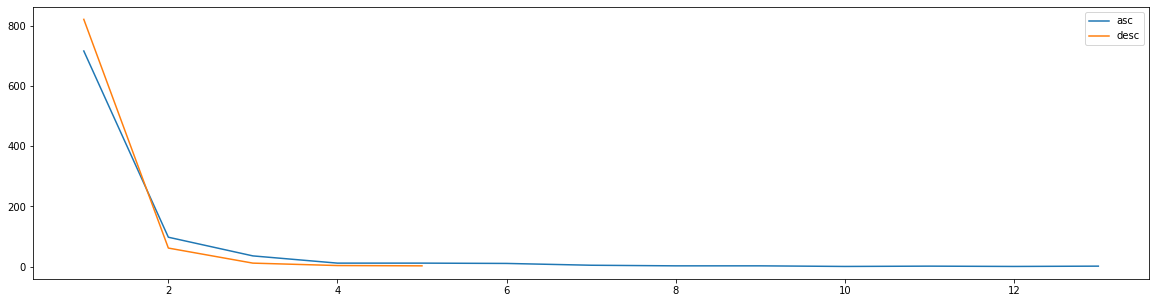

In [52]:
plt.figure(figsize=(20, 5))
y, x = np.histogram(min_changes_asc, bins=np.unique(min_changes_asc))
plt.plot(x[:-1], y, label='asc')
y, x = np.histogram(min_changes_desc, bins=np.unique(min_changes_desc))
plt.plot(x[:-1], y, label='desc')
plt.legend()

In [29]:
plt.figure(figsize=(20, 18))
num_samples = 3
for origin, adv in tqdm(zip(origin_samples, adv_samples)):
    origin_tokens = [token for (token, score) in origin['supervised']]
    if origin['label'] != origin['prediction']:
        origin_sal = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal = [score for (token, score) in origin['supervised']]
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal = [score for (token, score) in adv['unsupervised']]
    
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)
    # 3 parts: remain the same, inserted, deleted
    origin_tokens = [origin_tokens[idx] if val != -1 else '- - - {}'.format(origin_tokens[idx])
                    for (idx, val) in enumerate(actions_origin)]
    adv_tokens = [adv_tokens[idx] if val != -1 else '+ + + {}'.format(adv_tokens[idx])
                 for (idx, val) in enumerate(actions_adv)]

    plt.subplot(num_samples * 3, 1, 1 + i * 3)
    ax = sn.heatmap(data=np.array(origin_sal_unsup).reshape(1, -1),
                    xticklabels=origin_tokens,
                    cmap='YlGnBu')
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.title('Original sample: {}, confidence={:.2f}'.format(origin['label'],
                                                              origin['confidence']), fontsize=15)
    plt.tight_layout()

    plt.subplot(num_samples * 3, 1, 1 + i * 3 + 1)
    ax = sn.heatmap(data=np.array(adv_sal_unsup).reshape(1, -1),
                    xticklabels=adv_tokens,
                    cmap='YlGnBu')
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.title('Adversary sample: {} -> {}, confidence={:.2f}'.format(adv['label'],
                                                                     adv['prediction'],
                                                                     adv['confidence']), fontsize=15)
    plt.tight_layout()

0it [00:00, ?it/s]


ValueError: num must be 1 <= num <= 9, not 10

<Figure size 1440x1296 with 0 Axes>

## Saliency scores of remaining words between adversary sample and original sample

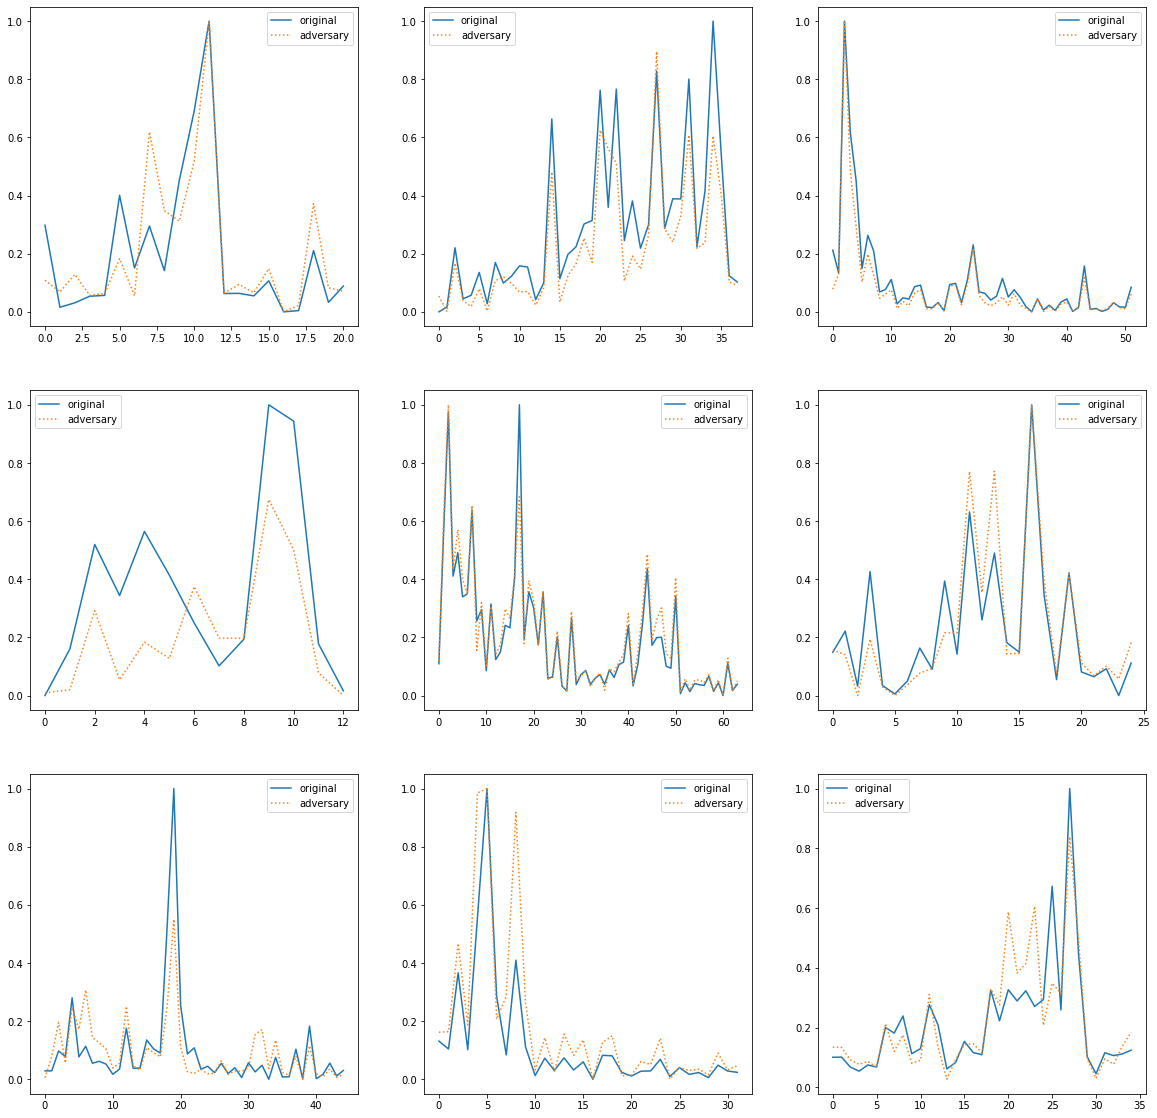

In [4]:
plt.figure(figsize=(20, 5))
saliency_convert = [0 for _ in range(4)]
for origin, adv in zip(origin_samples, adv_samples):
    pass
for i in range(9):
    adv = random.choice(sample_adv)
    index = adv['index']
    origin = sample_origin[index]
    origin_tokens = [token for (token, score) in origin['supervised']]
    origin_sal_sup = [score for (token, score) in origin['supervised']]
    if origin['label'] != origin['prediction']:
        origin_sal_unsup = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal_unsup = origin_sal_sup
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal_sup = [score for (token, score) in adv['supervised']]
    adv_sal_unsup = [score for (token, score) in adv['unsupervised']]

    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)
    # 3 parts: remain the same, inserted, deleted
    delete_indices = [idx for (idx, val) in enumerate(
        actions_origin) if val == -1]
    insert_indices = [idx for (idx, val) in enumerate(
        actions_adv) if val == -1]
    still_indices_origin = [
        idx for (idx, val) in enumerate(actions_origin) if val != -1]
    still_indices_adv = [
        idx for (idx, val) in enumerate(actions_adv) if val != -1]
    
    still_tokens = [origin_tokens[idx] for idx in still_indices_origin]
    still_scores_origin = [origin_sal_unsup[idx] for idx in still_indices_origin]
    still_scores_adv = [adv_sal_unsup[idx] for idx in still_indices_adv]

    x = range(len(still_tokens))
    plt.subplot(331 + i)
    plt.plot(x, still_scores_origin, label='original', linestyle='-')
    plt.plot(x, still_scores_adv, label='adversary', linestyle=':')
#     plt.xticks(x, still_tokens, rotation=60, ha="right")
    plt.legend()

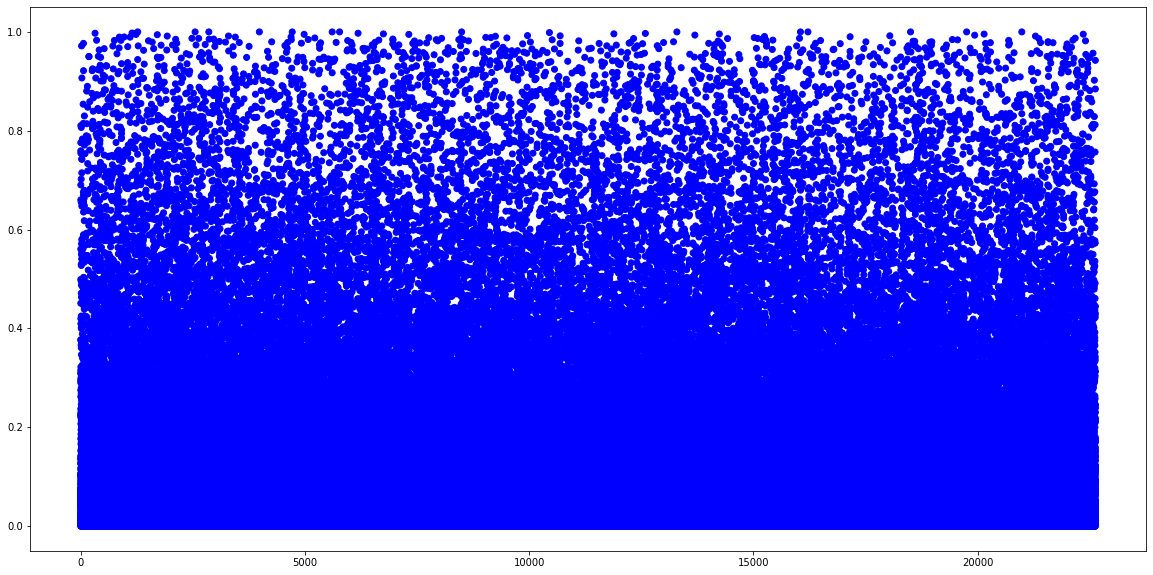

In [41]:
# Calculate how many samples' decisions are flipped due to flip of saliency
x = []
colors = []
flip_changed = []
flip_unchanged = []
flips = []
for adv in sample_adv:
    index = adv['index']
    origin = sample_origin[index]
    origin_tokens = [token for (token, score) in origin['supervised']]
    origin_sal_sup = [score for (token, score) in origin['supervised']]
    if origin['label'] != origin['prediction']:
        origin_sal_unsup = [score for (token, score) in origin['unsupervised']]
    else:
        origin_sal_unsup = origin_sal_sup
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal_sup = [score for (token, score) in adv['supervised']]
    adv_sal_unsup = [score for (token, score) in adv['unsupervised']]
    
    actions_origin, actions_adv = diff(origin_tokens, adv_tokens)
    # 3 parts: remain the same, inserted, deleted
    sal_diff = [abs(o - a) for (o, a) in zip(origin_sal_unsup, adv_sal_unsup)]
    flip_changed.extend([d for (i, d) in enumerate(sal_diff) if actions_origin[i] == -1])
    flip_unchanged.extend([d for (i, d) in enumerate(sal_diff) if actions_origin[i] != -1])

    flips.extend([d for (i, d) in enumerate(sal_diff) if actions_origin[i] == -1])
    flips.extend([d for (i, d) in enumerate(sal_diff) if actions_origin[i] != -1])
    x.extend([index for _ in range(len(adv_tokens))])
    colors.extend(['c' for i in range(len(adv_tokens)) if sal_diff[i] == -1])
    colors.extend(['b' for i in range(len(adv_tokens)) if sal_diff[i] != -1])

plt.figure(figsize=(20, 10))
plt.scatter(x, flips, c=colors)
plt.show()

In [25]:
np.histogram(np.abs(flip_unchanged), bins=10)

(array([227529,  40012,  14612,   6714,   3520,   2146,   1283,    801,
           442,    169]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [26]:
np.histogram(np.abs(flip_changed), bins=10)

(array([13488,  6804,  4213,  2748,  1965,  1433,  1117,   896,   809,
          633]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

## The supervised / unsupervised saliency scores are mostly same.

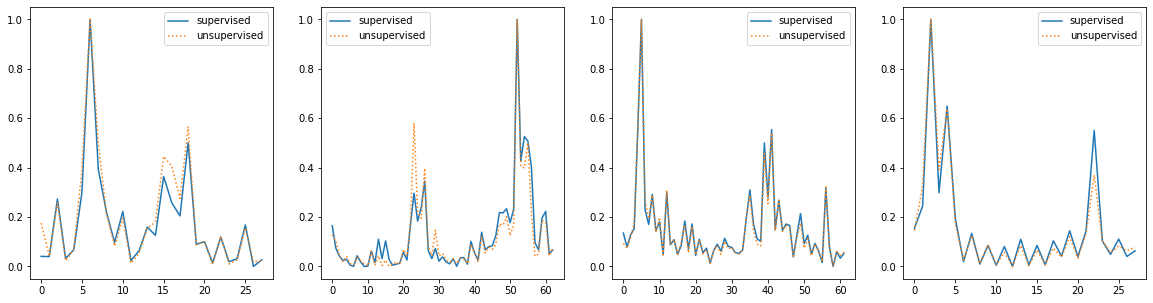

In [25]:
plt.figure(figsize=(20, 5))
for i in range(4):
    adv = random.choice(adv_samples)
    index = adv['index']
    adv_tokens = [token for (token, score) in adv['supervised']]
    adv_sal_sup = [score for (token, score) in adv['supervised']]
    adv_sal_unsup = [score for (token, score) in adv['unsupervised']]

    x = range(len(adv_tokens))
    plt.subplot(141 + i)
    plt.plot(x, adv_sal_sup, label='supervised', linestyle='-')
    plt.plot(x, adv_sal_unsup, label='unsupervised', linestyle=':')
#     plt.xticks(x, adv_tokens, rotation=60, ha="right")
    plt.legend()